# TL;DR:

We've been training buy/sell "classifiers" on various data sets and optimizing various parameters. We've only been able to achieve classifications that are within the margin of error for random. This can be attributed to a variety of factors. First our approach might be inherently doomed, etc. Second our parameters might not be optimized. Third our computational power is limited. It would be fun to train on larger datasets and explore a wider range of parameters, but it took  7 hours to create a classifier with a modest collection of data and parameters. Still we remain optimistic that future endeavors might yield lambos for all.

### Libraries

In [1]:
# TIME - Lord Chronos, Destroyer of All
import time

# Data Processing
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

# SciKit
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Poloniex
from poloniex import Poloniex
polo = Poloniex()

### Base Data

We look at 4 hour periods over the last 450 days. This is roughly the biggest length that we can use without corrupted data from Poloniex (eg. volume is zero, trading pair isn't that old, etc.).

We'll use trPairs as our training set.

In [2]:
params = {
    'period' : 14400,    # 4 hours
    'length' : 2700,     # 4 hours * 2700 = 450 days
    'end' : time.time(), # Now
}
params['start'] = params['end'] - params['length'] * params['period']  # 450 days ago

pairs = [
    'USDT_BTC',
    'USDT_ETH',
    'BTC_ETH',
    'BTC_NMC',
    'USDT_XRP',
    'BTC_DASH',
    'USDT_DASH',
    'USDT_ETC',
    'USDT_LTC',
    'USDT_NXT',
    'USDT_REP',
    'USDT_STR',
    'USDT_XMR',
    'USDT_ZEC',
    #'USDT_BCH',
    'BTC_XRP',
    'BTC_LTC',
    'BTC_XMR',
    'BTC_FCT',
    'BTC_MAID',
    'BTC_BTS'
]
trPairs = pairs[:6]

### Load Data

A function that processes and returns a pandas dataframe of historical market data from Poloniex. We calculate several moving averages and the hold value. We estimate the exchange price as the average of 'open' and 'weightedAverage' in the period following the signal in order to approximate lag. We hope to improve on this.

In [3]:
#Volume Weighted Moving Averages
mas = [4,8,16,32,64,128,256]

def vwma(price,volume,ma):
    return ( price * volume ).rolling(ma).sum() / volume.rolling(ma).sum()

In [4]:
def loadPolo(pair, params):
    
    raw = polo.returnChartData(currencyPair=pair,period=params['period'],start=params['start'],end=params['end'])
    
    # Generate dataframe from raw poloniex data
    df={ col:[]  for col in list(raw[0].keys()) }
    for i in range(len(raw)):
        for col in list( raw[0].keys()):
            df[col].append( float( raw[i][col] ) )
    df = pd.DataFrame( df, index=pd.to_datetime(df['date'],unit='s'))
    
    # Calculate price, hold value, and moving averages
    df.loc[:,'price'] = (( df.open + df.weightedAverage )/2).shift(-1)
    df.loc[:,'hold'] = np.log( df['price'].div( df['price'].iloc[0] ) )
    for ma in mas:
        df.loc[ma:,ma] = vwma(df['weightedAverage'],df['volume'],ma)
        
    # Check for bad values
    for i in range( max(mas), len(df['volume']) ):
        if( df['volume'].iloc[i]  == 0 ): print(pair + ' ' + str(i))    
    
    return df

### Process Data

This function returns a data set and target values.

The data consists of open, close, high, and low columns. The columns are normalized by the weightedAverage, then rescaled logarithmically, then linearly scaled by 100 so values are roughly between 1 and -1. Ideally we would add columns for weighted averages and other indicators.

The target values are zero or one depending on the sign of the change in price.

We're considering adding the trading pair to the base, combining all market data into time slices, and the different possible shapes of data.

In [5]:
# Process dataframe into base and target
def processDf(df):
    return [
        100 * np.log( np.array(
            pd.concat([ 
                df[ mas + ['open','close','high','low'] ].div(df.weightedAverage,axis=0),
                df['volume'].div( df['volume'].mean() )
            ],axis=1).iloc[max(mas):-2]
        )),
        np.array([ (1 if df.price.iloc[i] < df.price.iloc[i+1] else 0) for i in range(len(df)-2)]) ]

### Load and Process All Pairs

For each trading pair we store its dataframe, base set, and target set in the dictionary dfs.

In [6]:
%%time
dfs = {}
for pair in pairs:
    dfs[pair]={};
    dfs[pair]['df'] = loadPolo(pair,params)
    dfs[pair]['base'], dfs[pair]['df'].loc[:-2,'target'] = processDf( dfs[pair]['df'] )
    time.sleep(0.1)

print( 'Loaded {} pairs of length {}\n\n'.format(
    len(dfs),
    len(dfs[pairs[0]]['df'])
))

Loaded 20 pairs of length 2700


CPU times: user 7.25 s, sys: 144 ms, total: 7.4 s
Wall time: 33.5 s


### Search for Optimal Classifier

We use the function GridSearchCV to optimize the parameters (kernel, C, gamma) for our classifier. We set refit=True so that clf saves the best classifier in clf.best\_estimator\_. The base set and the target set are constructed by concatenating the bases and targets of the first two trading pairs, USDT_ETH and BTC_ETH.

Ideally we would expand our parameters and use a larger training set, but this is not realistic under present computational constraints. The computation below was 2 minutes using a single trading pair. Initially our grid spanned two kernels, linear and rbf, but we removed linear kernel because it was never the optimal kernel and it greatly increased the computation time. We hope to optimize over multiple classifiers in the future as we begin work with ensemble methods.

In [7]:
%%time
clf = GridSearchCV(
        SVC(),
        {
            'kernel':['rbf'], 
            'C':[65,70,75], 
            'gamma':[0.00005, 0.0001, 0.0002]
        }, 
        refit=True
    ).fit(
        [base for X in [ dfs[pair]['base'] for pair in trPairs ] for base in X],
        [target for y in [ dfs[pair]['df']['target'].iloc[max(mas):-2] for pair in trPairs ] for target in y]
    )
print('Best accuracy: {:.2f}% at {}\n\n'.format( 100*clf.best_score_, clf.best_params_ ))

Best accuracy: 51.33% at {'gamma': 0.0001, 'C': 65, 'kernel': 'rbf'}


CPU times: user 7min 38s, sys: 2.96 s, total: 7min 41s
Wall time: 7min 41s


### Test Model Against Strange

We test the model generated by our base data and optimized parameters against various trading pairs 

### Compute Value

We use the same old function to get the value of a portfolio over time. The total includes compounded returns and approximate trading fee. 

In [8]:
# Use Last/Open average for price. (or better)
def getValues(price,signal):
    value = 1.0
    values = []
    dates = []
    paid = False
    for i, sig in signal.iteritems():
        if sig and not paid:
            paid = price[i]
        elif not sig and paid:
            value *= price[i] / paid
            value *= 0.9975 * 0.9975
            paid = False
        values.append(value)
        dates.append(i)
    return pd.Series(values,index=dates)

### Backtest

This function gets the values and related results for the target strategy and our classifier's strategy.

In [9]:
def getResult(pair,clf,df,base):

    # Get estimate from classifier
    df.loc[max(mas):-2,'clf'] = clf.best_estimator_.predict( base )

    # Get values and results of target and classifier
    df['targetVal'] = np.log(getValues(df['price'],df['target']))
    df['clfVal'] = np.log(getValues(df['price'],df['clf']))

    result = pd.Series({
        'pair':pair,
        'score':'{:.2f}%'.format(100*clf.best_estimator_.score(base,df['target'].iloc[max(mas):-2])),
        'clf':'{:.2f}'.format(df['clfVal'].iloc[-2]),
        'hold':'{:.2f}'.format( df['hold'].iloc[-2] ),
        'ratio':'{:.2f}'.format( np.log( np.exp(df['clfVal'].iloc[-2]) / np.exp(df['hold'].iloc[-2] ) ) ),
        'target':'{:.2f}'.format(df['targetVal'].iloc[-3])
    })
    return df, result

### Results for All Pairs

We get the results for every trading pair and display them in a table. The ratio is the log of our classifier divided by holding. Please be aware that the pairs in trPairs are the training set.

In [10]:
%%time
results = pd.DataFrame(columns=['pair','score','ratio','clf','hold','target'])
for pair in pairs:
    dfs[pair]['df'], dfs[pair]['result'] = getResult( pair, clf, dfs[pair]['df'], dfs[pair]['base'])
    results = results.append(dfs[pair]['result'],ignore_index=True)

iplot( ff.create_table(results) ) 

CPU times: user 1min 6s, sys: 28 ms, total: 1min 6s
Wall time: 1min 6s


### Graph Results

We graph the values of our classifier's strategy versus holding.

In [11]:
def graphResult(pair,df,result):
    print('{} \n{} Accuracy \n{} Classifier \n{} Hold \n{} Target'.format(
        pair,
        result['score'],
        result['clf'],
        result['hold'],
        result['target']
    ))

    #Plot values
    df.plot(y=['weightedAverage','clfVal','hold'],secondary_y=['clfVal','hold'],figsize=(10,5))
    plt.ylabel("Log Scale FTW")
    plt.show()

USDT_BTC 
56.76% Accuracy 
2.40 Classifier 
2.22 Hold 
15.44 Target


/home/ahab/Projects/backtest/backtest_env/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



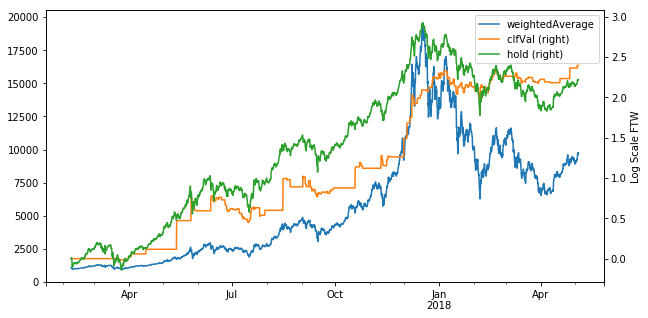

USDT_ETH 
56.92% Accuracy 
5.35 Classifier 
4.25 Hold 
21.32 Target


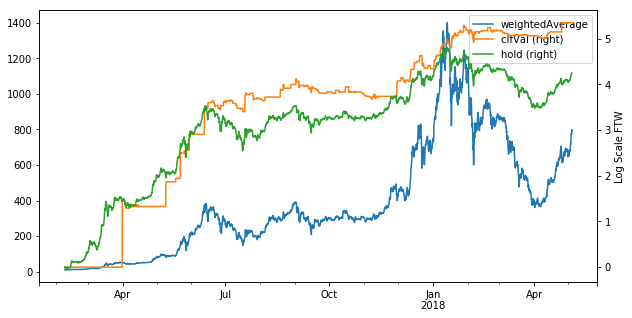

BTC_ETH 
56.27% Accuracy 
2.55 Classifier 
2.03 Hold 
15.58 Target


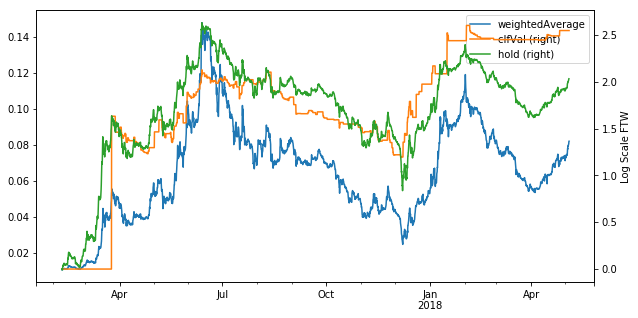

BTC_NMC 
58.68% Accuracy 
1.74 Classifier 
0.00 Hold 
19.71 Target


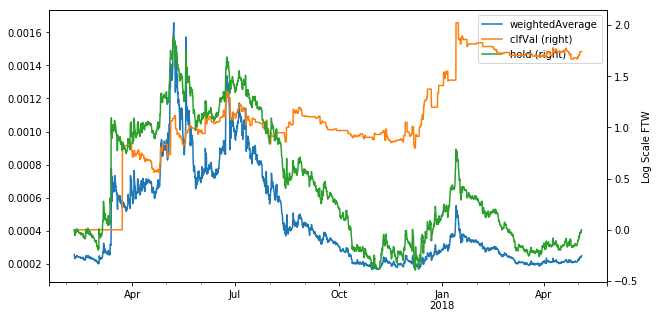

USDT_XRP 
58.80% Accuracy 
9.15 Classifier 
4.96 Hold 
27.82 Target


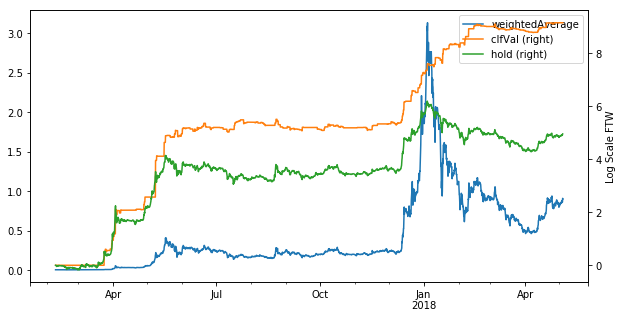

BTC_DASH 
54.87% Accuracy 
2.52 Classifier 
1.14 Hold 
17.58 Target


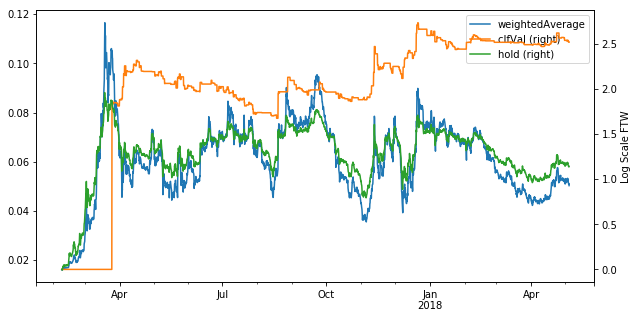

USDT_DASH 
53.89% Accuracy 
4.01 Classifier 
3.37 Hold 
23.41 Target


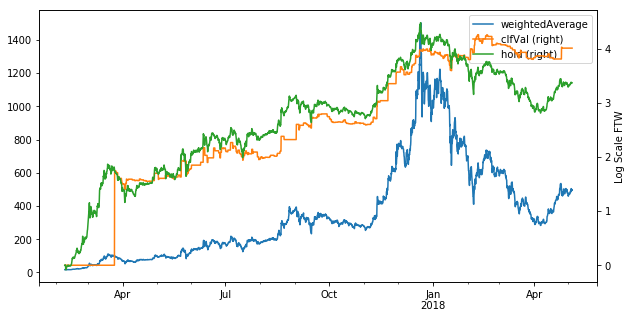

USDT_ETC 
52.42% Accuracy 
1.86 Classifier 
2.75 Hold 
23.61 Target


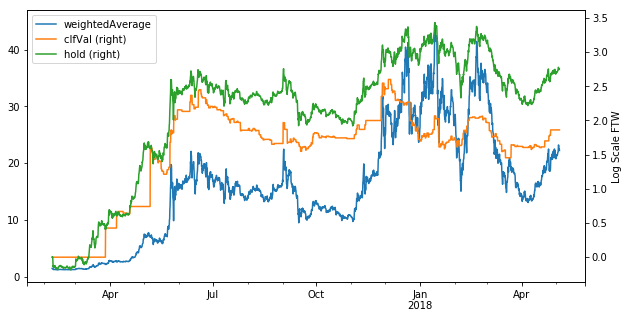

USDT_LTC 
52.74% Accuracy 
2.72 Classifier 
3.72 Hold 
22.95 Target


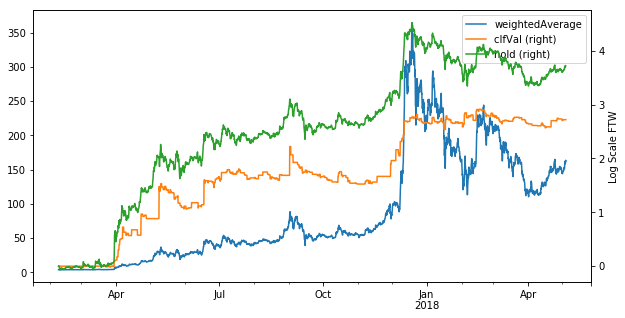

USDT_NXT 
53.24% Accuracy 
3.23 Classifier 
3.30 Hold 
33.03 Target


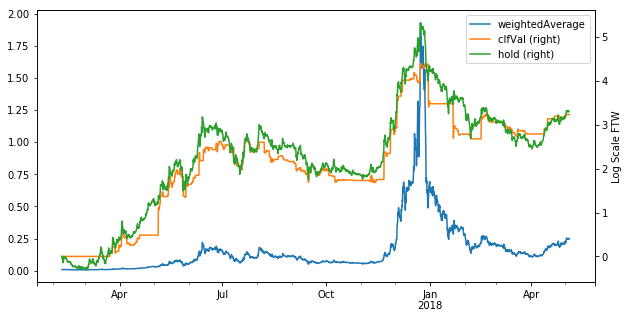

USDT_REP 
51.19% Accuracy 
1.73 Classifier 
2.26 Hold 
26.97 Target


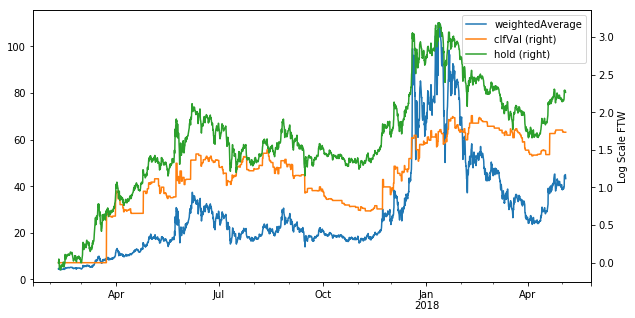

USDT_STR 
52.62% Accuracy 
2.89 Classifier 
5.24 Hold 
35.36 Target


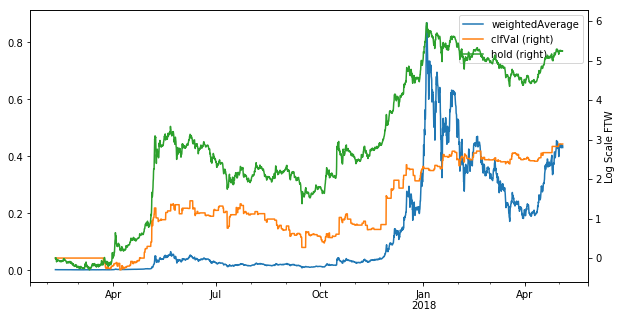

USDT_XMR 
52.25% Accuracy 
2.33 Classifier 
2.96 Hold 
23.19 Target


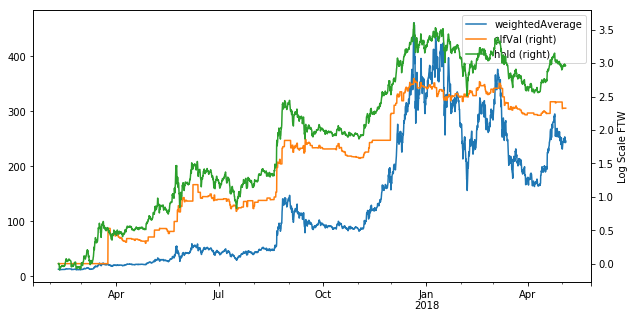

USDT_ZEC 
53.97% Accuracy 
2.00 Classifier 
2.16 Hold 
24.39 Target


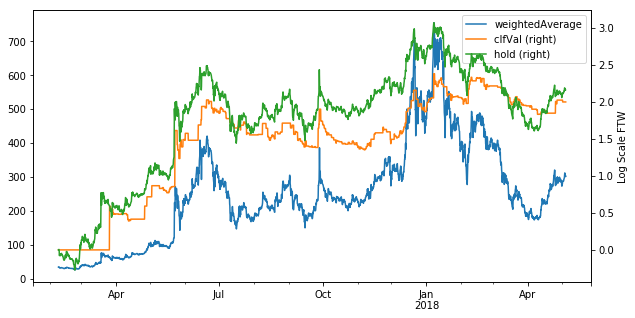

BTC_XRP 
56.27% Accuracy 
3.17 Classifier 
2.74 Hold 
22.97 Target


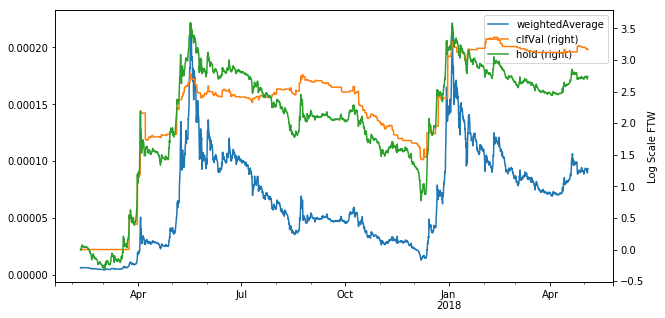

BTC_LTC 
53.60% Accuracy 
1.14 Classifier 
1.50 Hold 
15.60 Target


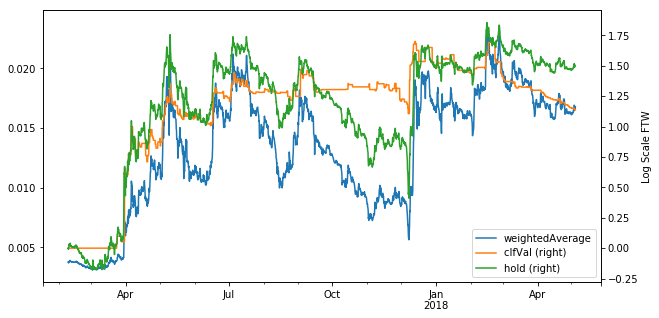

BTC_XMR 
51.43% Accuracy 
-0.56 Classifier 
0.74 Hold 
15.98 Target


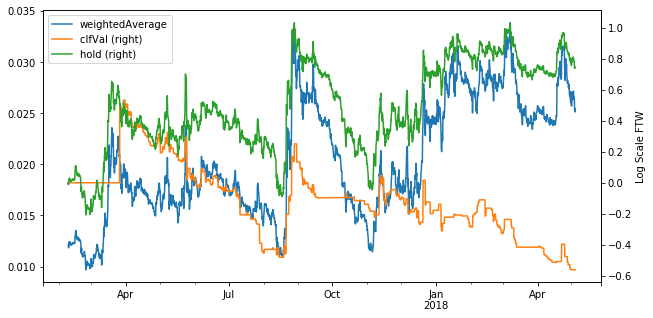

BTC_FCT 
54.01% Accuracy 
0.63 Classifier 
-0.10 Hold 
24.02 Target


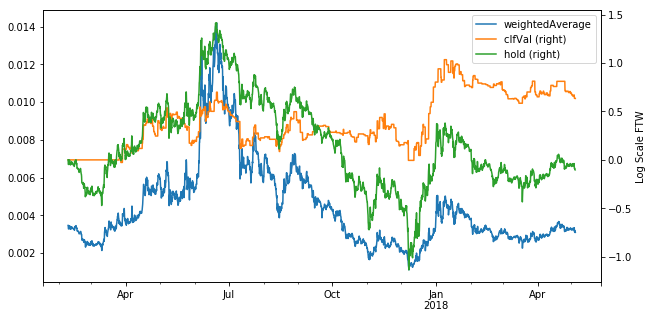

BTC_MAID 
52.83% Accuracy 
-0.88 Classifier 
-1.32 Hold 
18.53 Target


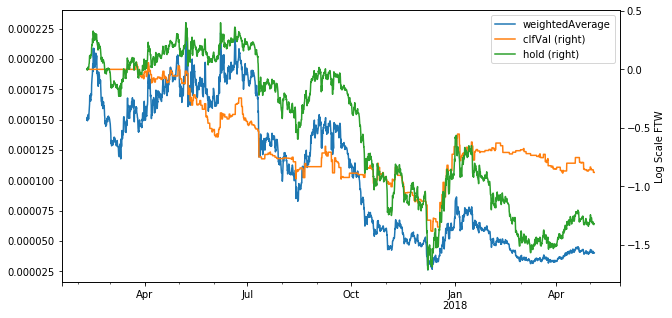

BTC_BTS 
52.66% Accuracy 
1.70 Classifier 
2.27 Hold 
28.65 Target


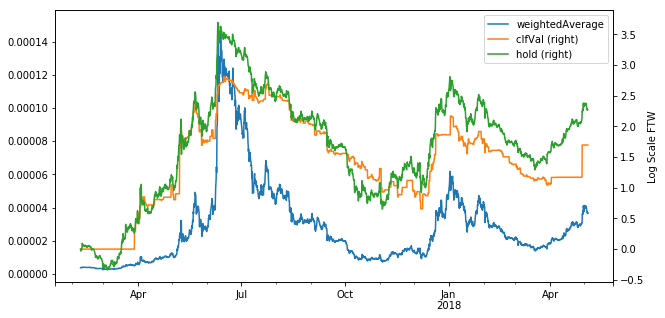

In [12]:
for pair in pairs:
    graphResult(pair,dfs[pair]['df'],dfs[pair]['result'])